## Pattern Recognition - Electrical & Computer Engineering
## 2023 Aristotle University Thessaloniki
### Authors: Antonios Antoniou 9482, Konstantinos Kalamaras 9716
### Emails: aantonii@ece.auth.gr, kkalamar@ece.auth.gr
#### Deliverables A, B, C of the semester assignment.

In [18]:
# First, we load the data. We then have to:
#  - Split it into the training and testing set (50%-50%)
#  - Split each of those sets into the features and labels (which is the last column)

import numpy as np
from typing import Union, List, Dict, Tuple

from sklearn import model_selection
from sklearn import metrics
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

filename = "dataset.csv"
ds = np.loadtxt(filename, delimiter=",", dtype=np.float64)
train_set, test_set = model_selection.train_test_split(ds, test_size=0.5, shuffle=True, random_state=0)
X_train, y_train = train_set[:, 0:2], train_set[:, 2]
X_test, y_test = test_set[:, 0:2], test_set[:, 2]

In [19]:
'''
Splits the test samples into correctly placed and misclassified ones.
'''
def split_correct_incorrect(X_test, y_test, y_pred) -> Tuple[List,List,List,List]:
    filter_hit = [y_test == y_pred]
    filter_miss = [y_test != y_pred]
    X_c, y_c = X_test[tuple(filter_hit)], y_test[tuple(filter_hit)]
    X_miss, y_miss = X_test[tuple(filter_miss)], y_test[tuple(filter_miss)]
    return X_c, y_c, X_miss, y_miss

'''
Uses the accuracy score in order to calculate the classification error.
'''
def get_classification_error(y_test, y_pred):
    acc = metrics.accuracy_score(y_test, y_pred)
    return (1 - acc).round(3) * 100

'''
Returns the classification error, when the accuracy has been pre-computed.
'''
def get_classification_error_from_acc(accuracy: float):
    return (1 - accuracy).round(3) * 100

'''
Plots the split samples on the plot of a decision boundary.
Adds text on the bottom right, displaying the classification error.
'''
def plot_on_boundary_display(
        plot: DecisionBoundaryDisplay,
        X_c, y_c, X_miss, y_miss, cerror,
        sc=100, smiss=49
) -> DecisionBoundaryDisplay:
    # Each class gets its own color.
    # If a test sample has been misclassified, we assign a different symbol for it.
    # For that purpose, we are splitting the test samples into correctly and incorrectly classified ones.
    plot.ax_.scatter(X_c[:,0], X_c[:,1], c=y_c, marker=".", s=sc, edgecolor="black")
    plot.ax_.scatter(X_miss[:,0], X_miss[:,1], c=y_miss, marker="X", s=smiss, edgecolor="black")
    plot.ax_.text(
        5., -1, s=f"Class. error : {cerror:.1f}%",
        style="oblique", bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 3}
    )
    return plot

'''
Calculates the prediction of a model on the test data,
plots the decision boundary and distribution of datapoints.
'''
def plot_model(
    model: Union[KNeighborsClassifier, SVC],
    X_test, y_test, gres
) -> DecisionBoundaryDisplay:
    y_pred = model.predict(X_test)
    X_c, y_c, X_miss, y_miss = split_correct_incorrect(X_test, y_test, y_pred)
    classification_error = get_classification_error(y_test, y_pred)

    db_plot = DecisionBoundaryDisplay.from_estimator(model, X_test, grid_resolution=gres)
    db_plot = plot_on_boundary_display(db_plot, X_c, y_c, X_miss, y_miss, classification_error)
    return db_plot

'''
Checks if an argument is a single value, or a list of values of the given type \@ t \@.
In the former case, turns the value into a list of size 1, otherwise returns the \@ arg \@.
'''
def turn_into_list(arg, t: type):
    return [arg] if type(arg) == t else arg

'''
Gets a list of arguments, and turns them all into lists, in order to iterate over all of them.
'''
def make_args_lists(
    C: Union[float, List[float]],
    kernel: Union[str, List[str]],
    gamma: Union[str, List[str]],
    decision_function_shape: Union[str, List[str]]
) -> Tuple[List[float], List[str], List[str], List[str]]:
    C = turn_into_list(C, float)
    kernel = turn_into_list(kernel, str)
    gamma = turn_into_list(gamma, str)
    decision_function_shape = turn_into_list(decision_function_shape, str)
    return C, kernel, gamma, decision_function_shape

## Question A (Bayes Classifier assuming Gaussian distribution)

In [36]:
def decimal_and_log_probabilities(Y: np.ndarray, K: int, N: int, labels: List[float]) -> Tuple[np.ndarray, np.ndarray]:
    P = np.empty((K))
    for i in range(K):
        l = labels[i]
        label_filter = [Y == l]
        P[i] = np.count_nonzero(label_filter) / N
    lnP = [np.log(p) for p in P]
    return P, lnP

def means_per_class(Y: np.ndarray, D: int, K: int, labels: List[float]) -> np.ndarray:
    mu = np.zeros((D, K))
    for i in range(K):
        l = labels[i]
        label_filter = [Y == l]
        mu[:, i] = np.mean(X_test[tuple(label_filter)], axis=0)
    return mu

def one_cov_matrix_predict(
        X_train: np.ndarray, X_test: np.ndarray,
        K:int, mu: np.ndarray, lnP: np.ndarray, labels: List[float]
) -> np.ndarray:
    C = np.cov(X_train, rowvar=False) # `rowvar=False`: each row of X_train is a sample
    C_inv = np.linalg.inv(C)

    Ntest = X_test.shape[0]
    y_pred = np.empty((Ntest))
    gi = np.empty((K))
    for i in range(Ntest):
        xn = X_test[i, :].T
        for k in range(K):
            d = xn - mu[:, k]
            gi[k] = -0.5 * np.dot(np.dot(d, C_inv), d) + lnP[k]
        y_pred[i] = labels[np.argmax(gi)]
    return y_pred

def individual_cov_matrices_predict(
    X_train: np.ndarray, X_test: np.ndarray,
    K: int, mu: np.ndarray, lnP: np.ndarray, labels: List[float]
) -> np.ndarray:
    Cs = np.zeros((K, D, D))
    Cs_inv = np.zeros((K, D, D))
    lndet_C = np.ndarray((K))
    for i in range(K):
        l = labels[i]
        label_filter = [y_test == l]
        y_k = X_train[tuple(label_filter)]
        Cs[i] = np.cov(y_k, rowvar=False)
        Cs_inv[i] = np.linalg.inv(Cs[i])
        lndet_C[i] = np.log(np.linalg.det(Cs[i]))

    Ntest = X_test.shape[0]
    y_pred =  np.empty((Ntest))
    gi = np.empty((K))
    for i in range(Ntest):
        xn = X_test[i, :].T
        for k in range(K):
            mk = mu[:, k]
            Ck_inv = Cs_inv[k]
            gik = - 0.5 * np.dot(np.dot(xn, Ck_inv), xn)
            gik += np.dot(np.dot(Ck_inv, mk), xn)
            gik += - 0.5 * np.dot(np.dot(mk, Ck_inv), mk) - 0.5 * lndet_C[k] + lnP[k]
            gi[k] = gik
        y_pred[i] = labels[np.argmax(gi)]
    return y_pred

def bayes_boundary_display(
    predict_function: callable,
    X: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, y_pred: np.ndarray,
    D: int, K: int, mu: np.ndarray, lnP: np.ndarray, labels: np.ndarray, title: str
):
    X_c, y_c, X_miss, y_miss = split_correct_incorrect(X_test, y_test, y_pred)
    cerror = get_classification_error(y_test, y_pred)
    frange = np.zeros((D, 2))
    for i in range(D):
        frange[i] = [np.min(X[:, i]), np.max(X[:, i])]

    feature_1, feature_2 = np.meshgrid(
        np.linspace(frange[0, 0], frange[0, 1], num=100),
        np.linspace(frange[1, 0], frange[1, 1], num=100)
    )
    grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
    y_pred = np.reshape(
        predict_function(X_train, grid, K, mu, lnP, labels),
        feature_1.shape
    )
    display = DecisionBoundaryDisplay(xx0=feature_1, xx1=feature_2, response=y_pred)
    display.plot()
    plot_on_boundary_display(display, X_c, y_c, X_miss, y_miss, cerror)
    display.ax_.set_title(title)


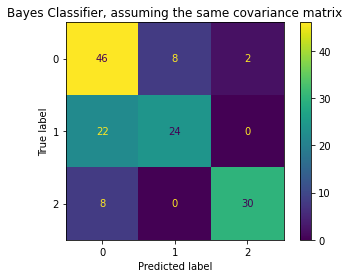

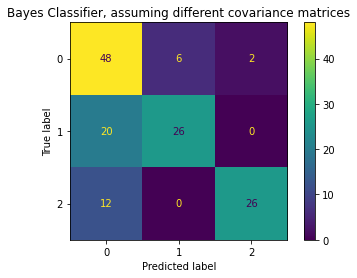

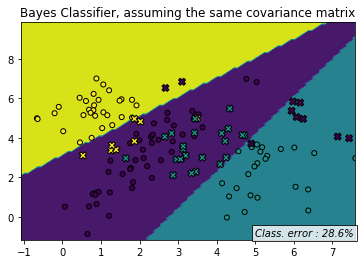

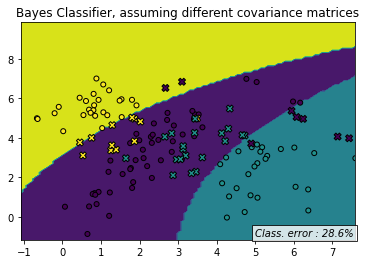

In [37]:
# We extract the K, D, and N constants:
# Number of classes, dimension of samples, and number of total samples.
# ##########
# Extract the probabilities of each class' occurence from the entirety of the dataset.

labels = np.unique(y_test)
K = len(labels)
D = X_test.shape[1]
N = ds.shape[0]

X, Y = ds[:, 0:D], ds[:, D]
P, lnP = decimal_and_log_probabilities(Y, K, N, labels)
mu = means_per_class(y_test, D, K, labels)

title_A = "Bayes Classifier, assuming the same covariance matrix"
title_B = "Bayes Classifier, assuming different covariance matrices"

# First, we assume that the covariance matrices are the same for all classes.
# We only calculate one such matrix `C`, from the training data
y_pred_A = one_cov_matrix_predict(X_train, X_test, K, mu, lnP, labels)
cm_A = metrics.confusion_matrix(y_test, y_pred_A)
cmd_A = metrics.ConfusionMatrixDisplay(cm_A)
cmd_A.plot()
cmd_A.ax_.set_title(title_A)

y_pred_B = individual_cov_matrices_predict(X_train, X_test, K, mu, lnP, labels)
cm_B = metrics.confusion_matrix(y_test, y_pred_B)
cmd_B = metrics.ConfusionMatrixDisplay(cm_B)
cmd_B.plot()
cmd_B.ax_.set_title(title_B)

bayes_boundary_display(
    one_cov_matrix_predict, X, X_test, y_test,
    y_pred_A, D, K, mu, lnP, labels, title_A
)
bayes_boundary_display(
    individual_cov_matrices_predict, X, X_test, y_test,
    y_pred_B, D, K, mu, lnP, labels, title_B
)


## Question B (k-NN classifier for $i=\{1,...,10\}$)

In [22]:
def train_knn_classifiers(X_train, y_train, k: Union[int, List[int]]) -> Dict[int, KNeighborsClassifier]:
    k = turn_into_list(k, int)
    knnc = {}
    for n in k:
        knn_i = KNeighborsClassifier(n_neighbors=n)
        knn_i.fit(X_train, y_train)
        knnc[n] = knn_i
    return knnc

def plot_knn_classifier(model:KNeighborsClassifier, n_neighbors, X_test, y_test):
    db_plot = plot_model(model, X_test, y_test, 200)
    db_plot.ax_.set_title(f"KNeighborsClassifier using {n_neighbors} neighbor(s)")

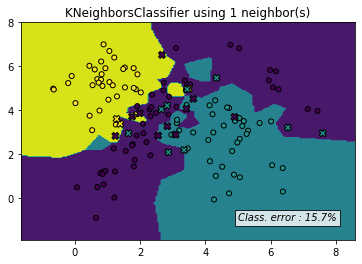

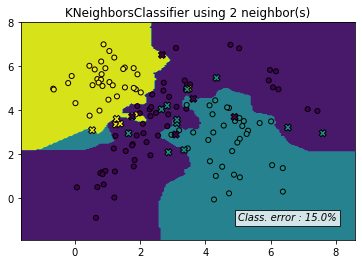

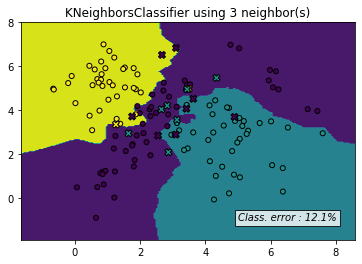

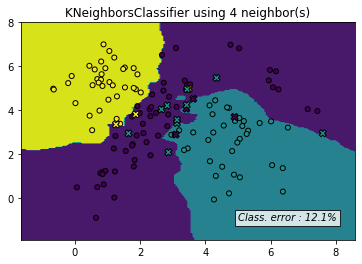

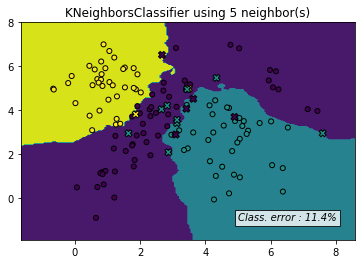

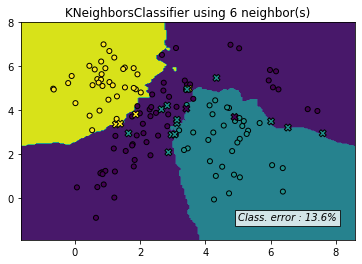

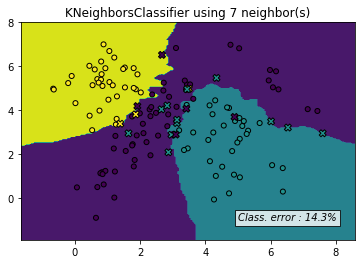

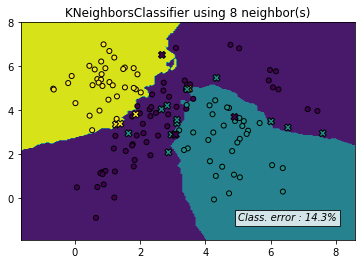

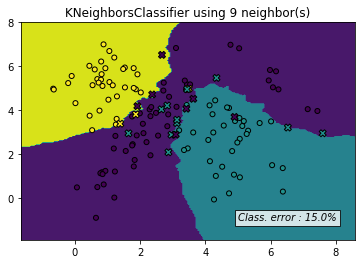

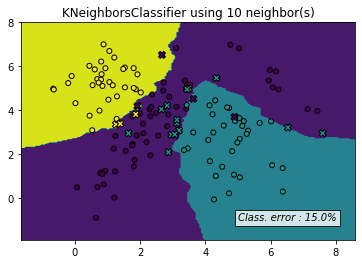

In [23]:
k_arr = [i for i in range(1,11)]
knns = train_knn_classifiers(X_train, y_train, k_arr)
for n,c in zip(knns.keys(), knns.values()):
    plot_knn_classifier(c, n, X_test, y_test)

## Question C (SVM, linear and RBF kernel)

In [24]:
# Here, we train SVC classifiers (i.e. SVM classifiers whose C value is non-zero)
# As known from the theory, C is a measure of how strictly
# we want all the training datapoints to be correctly classified
# ##########
# For linear SVM's \@ SVC(kernel="linear") \@, we use two implementations :
#   <ul>
#     <li> "ovo" : one-vs-one implementation for multiclass cases, like this one. </li>
#     <li> "ovr" : one-vs-rest implementation for multiple classes. </li>
#   </ul>
# ##########
# The options can be changed by :
#   <pre>
#     SVC(kernel="linear", decision_function_shape=["ovo"|"ovr"])
#   </pre>
# respectively for each of the two algorithms.
# ##########
# For SVC's with RBF kernels \@ SVC(kernel="rbf") \@ :
#   - We will implement a grid search, by extracting a validation set from the testing data.
#   - The values we will research are :
#     <ul>
#       <li> C </li>
#       <li> gamma </li>
#       <li> class_weight </li>
#       <li> decision_function_shape </li>
#     </ul>

from sklearn.utils.class_weight import compute_class_weight

'''
Keeps the hyperparameters used to train the best classifier,
when grid search is executed.
'''
class Training_info:
    def __init__(self):
        self.C = None
        self.gamma = None
        self.weights = None
        self.decision_function_shape = None
        self.error_rate = None

    def __init__(
        self,
        C: float,
        gamma: str,
        weights: Union[List[float], None],
        decision_function_shape: str,
        error_rate: float
    ):
        self.C = C
        self.gamma = gamma
        self.weights = weights
        self.decision_function_shape = decision_function_shape
        self.error_rate = error_rate

    def __str__(self):
        s = (f"training info : C={self.C}, gamma={self.gamma}, "
            f"weights={self.weights}, dec. function={self.decision_function_shape}, "
            f"error rate={self.error_rate}")
        return s

def train_linear_svm(X_train, y_train, shape: str) -> SVC:
    svmc = SVC(kernel="linear", decision_function_shape=shape)
    svmc.fit(X_train, y_train)
    return svmc

def plot_linear_svm(model: SVC, X_test, y_test, multiclass: str):
    db_plot = plot_model(model, X_test, y_test, 500)
    db_plot.ax_.set_title(f"Linear SVC : multiclass = {multiclass}")

def train_svc( # reminder: `*` differentiates the positional from the named arguments.
    X_train, y_train, *,
    C=1.0, kernel="rbf", gamma="scale",
    weights: Union[List[float], None]=None,
    decision_function_shape: str="ovr"
) -> SVC:
    svmc = SVC(C=C, kernel=kernel, gamma=gamma, class_weight=weights, decision_function_shape=decision_function_shape)
    svmc.fit(X_train, y_train)
    return svmc

'''
Executes a grid search over the options given.
Returns the SVC with the best metric.
'''
def grid_search(
    X_train, y_train, X_test, y_test, *,
    C: Union[float, List[float]]=1.0,
    kernel: Union[str, List[str]]="rbf",
    gamma: Union[str, List[str]]="scale",
    weights: Union[List, List[List], None]=[None],
    decision_function_shape: Union[str, List[str]]="ovr",
    verbose: bool=False
) -> Tuple[SVC, Training_info]:
    C, kernel, gamma, decision_function_shape = make_args_lists(C, kernel, gamma, decision_function_shape)

    # Initialize the values to be returned by the function.
    best_classifier = None
    info = None
    best_acc = 0.

    for c in C:
        for k in kernel:
            for g in gamma:
                for ds in decision_function_shape:
                    for w in weights:
                        if verbose:
                            print(f" >> Training with C: {c}, kernel: {k}, gamma: {g}, dec. function: {ds}, weights: {w}")
                        model = train_svc(
                            X_train, y_train, C=c, kernel=k, gamma=g,
                            weights=w, decision_function_shape=ds
                        )
                        y_pred = model.predict(X_test)
                        acc = metrics.accuracy_score(y_test, y_pred)
                        if acc > best_acc:
                            best_acc = acc
                            best_classifier = model
                            info = Training_info(c, g, w, ds, get_classification_error_from_acc(acc))
    return best_classifier, info

'''
Splits the training datapoints into support and non-support vectors.
Also returns the corresponding classes.
'''
def support_nonsupport_vectors(model: SVC, X_train, y_train) -> Tuple[List, List, List, List]:
    support_vecs = X_train[model.support_]
    support_c = y_train[model.support_]
    non_support_vecs = []
    non_support_c = []
    for i in range(len(X_train)):
        if i not in model.support_:
            non_support_vecs.append(X_train[i])
            non_support_c.append(y_train[i])
    return support_vecs, support_c, np.array(non_support_vecs), np.array(non_support_c)

'''
Plots the model's training datapoints (support vectors are plotted distinctively).
Then makes a plot like the rest: Correctly and improperly classified datapoints,
and a report on the classification error rate on the bottom right.
'''
def plot_rbf_svc(model: SVC, X_train, X_test, y_test, info: Training_info, gres):
    sv, sv_y, nsv, nsv_y = support_nonsupport_vectors(model, X_train, y_train)
    y_pred = model.predict(X_test)
    X_c, y_c, X_miss, y_miss = split_correct_incorrect(X_test, y_test, y_pred)
    classification_error = get_classification_error(y_test, y_pred)
    s = f"SVC(C: {info.C}, gamma: {info.gamma}, weights: {info.weights})[{info.decision_function_shape}]"

    db_plot = DecisionBoundaryDisplay.from_estimator(model, X_train, grid_resolution=gres)
    db_plot = plot_on_boundary_display(db_plot, X_c, y_c, X_miss, y_miss, classification_error)
    db_plot.ax_.set_title(s)

    train_plot = DecisionBoundaryDisplay.from_estimator(model, X_train, grid_resolution=gres)
    train_plot.ax_.scatter(sv[:,0], sv[:,1], s=49, marker='P', c=sv_y, edgecolor="black", label='Support vectors')
    train_plot.ax_.scatter(nsv[:,0], nsv[:,1], s=81, marker='.', c=nsv_y, edgecolor="black", label='Training samples')
    train_plot.ax_.set_title("Training set : " + s)
    train_plot.ax_.legend()

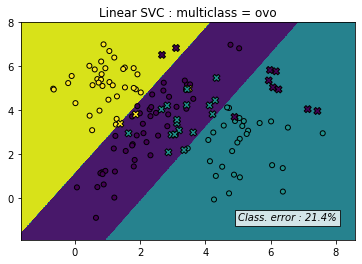

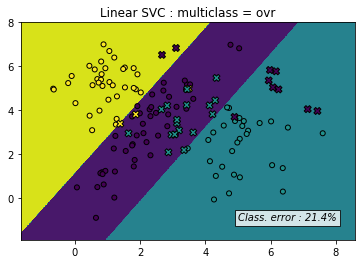

In [25]:
linear_svms = {}
shapes = ["ovo", "ovr"]
for s in shapes:
    linear_svms[s] = train_linear_svm(X_train, y_train, s)
for s,c in zip(shapes, linear_svms.values()):
    plot_linear_svm(c, X_test, y_test, s)

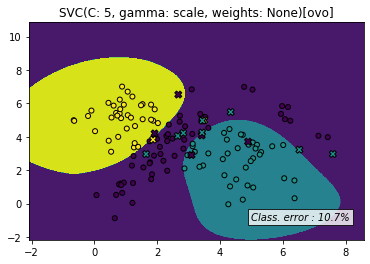

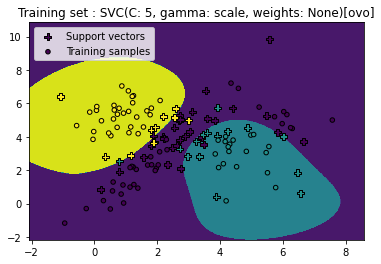

In [26]:
best_svc, info = grid_search(
    X_train, y_train, X_test, y_test,
    C=[1, 5, 10, 20, 50, 100],
    gamma=["scale", "auto"],
    weights=[None, "balanced"],
    decision_function_shape=["ovo", "ovr"],
    verbose=False
)
plot_rbf_svc(best_svc, X_train, X_test, y_test, info, 500)